In [ ]:
# !pip install -U langgraph langsmith

  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached xxhash-3.5.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached orjson-3.11.2-cp310-cp310-macosx_10_15_x86_64.macosx_11_0_arm64.macosx_10_15_universal2.whl.metadata (1.2 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pydantic_core-2.33.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached typing_inspection-0.4.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached jsonpatch-1.33-py2.py3-none

## Create a StateGraph
- Start by creating a StateGraph. A StateGraph object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot can call and edges to specify how the bot should transition between these functions.

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Message have type "list". The "add_message" function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list[str], add_messages]


graph_builder = StateGraph(State)

## Add a node
- Next add a "chatbot" node. **Nodes** represent units of work and are typically regular functions.

In [ ]:
# !pip install -U "langchain[openai]"

  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
  Using cached distro-1.9.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached jiter-0.10.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.1 MB/s eta 0:00:00
Using cached async_timeout-4.0.3-py3-none-any.whl (5.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.3/788.3 kB 32.3 MB/s eta 0:00:00
Using cached distro-1.9.0-py3-none-any.whl (20 kB)
Using cached jiter-0.10.0-cp310-cp310-macosx_11_0_arm64.whl (322 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.2/999.2 kB 33.6 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [langchain]11 [langchain]]


In [13]:
!pip install python-dotenv

  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.1-py3-none-any.whl (20 kB)


In [14]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()

llm = init_chat_model(
        model=os.getenv("MODEL_NAME"),
        model_provider="openai",
        base_url = os.getenv("OPENAI_BASE_URL"),
        api_key = os.getenv("OPENAI_API_KEY")
    )

In [15]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the note is used.
graph_builder.add_node("chatbot", chatbot)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `chatbot` already present.

## Add and `entry` point
- Add an `entry` point to tell the graph **where to start its work** each time it is run:

In [7]:
graph_builder.add_edge(START, "chatbot")

## Add and `exit` point
- Add an `exit` point to indicate **where the graph should finish execution.** This is helpful for more complex flows, but even in a simple graph like this, adding an end node improves clarity.

In [8]:
graph_builder.add_edge("chatbot", END)

## Compile the graph
- Before running the graph, we'll need to compile it. We can do so by calling `compile()` on the graph builder. This creates a `CompiledGraph` we can invoke on our state.

In [9]:
graph = graph_builder.compile()

## Visualize the graph (optional)
- You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

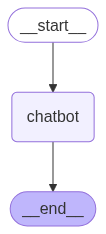

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

## Run the chatbot

In [16]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Okay, let's break down why the ocean is blue. It's a surprisingly complex topic involving physics and water itself! Here's a comprehensive explanation, layered from simple to more detailed:

**1. The Simple Answer: Scattering of Light**

*   **Sunlight is White (or a Spectrum):** Sunlight appears white to us, but it's actually made up of all the colors of the rainbow (red, orange, yellow, green, blue, indigo, violet).
*   **Water Molecules Interact with Light:** When sunlight hits the water, the water molecules interact with these different colors of light.
*   **Blue Light is Scattered More:**  Blue and violet light have shorter wavelengths than other colors (like red and orange).  Shorter wavelengths are scattered more effectively by the water molecules. This phenomenon is called **Rayleigh scattering**. Think of it like tiny obstacles (water molecules) deflecting the light.
*   **Our Eyes See the Scattered Blue:** Because blue light is scattered in all directions, it's wh